Make a truthset for each combination of (1) a specific exponential model of AAF distribution, (2) variant type (3) sample and region.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import attila_utils
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
from IPython.display import set_matplotlib_formats

In [2]:
import truth_sets_aaf as tsa
import pandas as pd
import multi_prec_recall as multipr

Read in model parameters into `expm` for all combinations and create a truthset for each combination storing the names of output VCFs in `outvcfs`.

In [3]:
expm = pd.read_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/exp_model.csv',
                   dtype={'lambda': 'category', 'region': 'category', 'sample': 'category', 'vartype': 'category', 'log10s2g': 'category'})

In [4]:
outvcfs = tsa.downsample_absolutely_all_vcfs(expm, topdir='/home/attila/projects/bsm/results/2019-03-18-truth-sets', seed=19760415)
pd.DataFrame({'outvcf': outvcfs}).to_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/outvcfs.csv', index=False)

Let's write the pathnames for the resulting truthset VCFs to a CSV file!

In [5]:
outvcfs = list(pd.read_csv('~/projects/bsm/results/2019-04-04-truth-sets-aaf/outvcfs.csv')['outvcf'])

The operation below does the following
1. prepare (filter) callsets at each combination of region and variant type
1. reduce callsets by removing nonvariants defined by the exponential model for all parameter combinations (log10s2g, lambda, sample)
1. calculate precision and recall for all those conditions

In [6]:
pr = multipr.run_all()
pr.to_csv('/home/attila/projects/bsm/results/2019-05-02-make-truth-sets/pr.csv', index=False)

Reloading saved precision--recall data

In [7]:
pr = multipr.read_pr_csv('/home/attila/projects/bsm/results/2019-05-02-make-truth-sets/pr.csv')

In [155]:
fg = multipr.plotter1(df=pr.loc[(pr['region'] == 'chr22') & (pr['vartype'] == 'snp'), :])

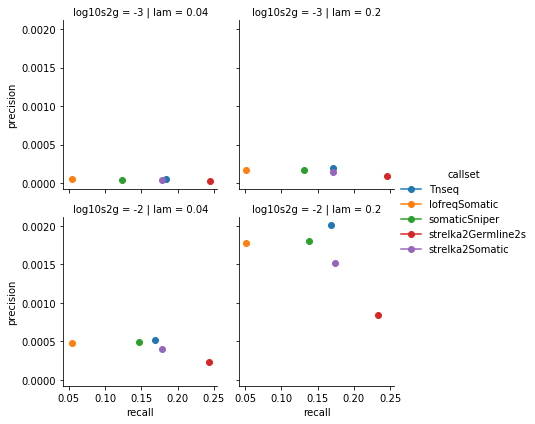

In [9]:
fg = multipr.plotter1(df=pr.loc[(pr['region'] == 'autosomes') & (pr['vartype'] == 'snp'), :])

In [157]:
fg = multipr.plotter1(df=pr.loc[(pr['region'] == 'chr22') & (pr['vartype'] == 'indel'), :])

In [158]:
fg = multipr.plotter1(df=pr.loc[(pr['region'] == 'autosomes') & (pr['vartype'] == 'indel'), :])

In [17]:
%connect_info

{
  "key": "e6f823c0-b39ab31fea1aaa1007a9b639",
  "iopub_port": 33837,
  "shell_port": 41105,
  "ip": "127.0.0.1",
  "signature_scheme": "hmac-sha256",
  "transport": "tcp",
  "kernel_name": "",
  "stdin_port": 49111,
  "hb_port": 58147,
  "control_port": 36401
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-09ff4cf9-6aa8-4a98-b74f-ef8a04a4d057.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
